In [1]:
%cd -q data/actr_reco

In [83]:
import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
with open("sampled.txt", "r") as f:
    users = f.readlines()
users = users[:150]
users = [user.strip() for user in users]
len(users)

150

In [5]:
word2vec_file = "../emo_mem_reco/word2vec_100.csv"
word2vec_df = pd.read_csv(word2vec_file, sep="\t", error_bad_lines=False, warn_bad_lines=False)
word2vec_df["item"] = list(zip(word2vec_df["track"], word2vec_df["artist"]))
word2vec_df = word2vec_df.set_index("item").drop(columns=["unique_id", "track_id", "track", "artist_id", "artist"])
w2v_cols = word2vec_df.columns.tolist()

/home/mreiterhaas/miniconda3/envs/polarice/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
dur_cols = ["track", "artist", "playcount", "track_listeners", "duration"]
durations = pd.read_csv("../emo_mem_reco/LFM-2b_track_artist_pc_ls_dur.txt", sep="\t", names=dur_cols)
durations["item"] = list(zip(durations["track"], durations["artist"]))
durations["duration_td"] = pd.to_timedelta(durations["duration"], unit="ms")
durations = durations.set_index("item").drop(columns=["track", "artist", "playcount", "track_listeners"])
durations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2495639 entries, ('Somebody That I Used to Know', 'Gotye') to ('Venus (12" Hellfire Mix)', 'Bananarama')
Data columns (total 2 columns):
 #   Column       Dtype          
---  ------       -----          
 0   duration     int64          
 1   duration_td  timedelta64[ns]
dtypes: int64(1), timedelta64[ns](1)
memory usage: 57.1+ MB


In [8]:
def load_file(filename):
    col_names = ['user', 'track', 'artist', 'album', 'gender', 'country', 'age', 'timestamp']
    events = pd.read_csv(filename, names=col_names,
                        quoting=3, sep="\t", header=None, encoding='utf-8'
                        )
    events["timestamp"] = pd.to_datetime(events["timestamp"])
    return events

In [10]:
def preprocess(events, use_content=True, calc_reward=True):
    events["prev_timestamp"] = events.groupby("user")["timestamp"].shift()
    events["gap"] = events["timestamp"] - events["prev_timestamp"]
    events["new_session"] = events["gap"] > pd.Timedelta("30min")
    events["new_session_int"] = events["new_session"].astype(int)
    events["session"] = events.groupby("user")["new_session_int"].cumsum()
    events["session_duration"] = events.groupby(["user", "session"])["timestamp"].transform(lambda x: x.iloc[-1] - x.iloc[0])
    events["item"] = list(zip(events["track"], events["artist"])) #, events["album"]))
    events["all_pos"] = 1
    
    if use_content:
        events = events.join(word2vec_df, on="item", how="left")
    
    if calc_reward:
        events = events.join(durations, on="item", how="left")
        events["timestamp_end"] = events["timestamp"] + events["duration_td"]
        events["timestamp_start_next"] = events["timestamp"].shift(-1)
        events["play_duration"] = (events["timestamp_start_next"] - events["timestamp"]).dt.seconds * 1000
        events["gap"] = (events["timestamp_start_next"] - events["timestamp_end"]).dt.seconds
        events["min_duration"] = events[["play_duration", "duration"]].min(axis=1)
        events["play_ratio"] = events["min_duration"] / events["duration"]
        
        def reward_function(play_ratio):
            if play_ratio >= 0.66:
                return 1
            elif play_ratio > 0.33 and play_ratio < 0.66:
                return 0
            else:  # play_ratio <= 0.33:
                return -1

        events["reward"] = events["play_ratio"].apply(reward_function)
    
    return events

In [40]:
unique_items = set()
total_les = 0
total_missing_content = 0
total_missing_duration = 0
total_sessions = 0

for user in tqdm.tqdm(users):
    filename = f"user_split/listening_events_2019_{user}.tsv"
    events = load_file(filename)
    events = preprocess(events)
    
    num_missing_content = len(events[events[w2v_cols].eq(0).all(axis=1)])
    num_missing_duration = len(events[events["duration"] == 0])
    
    unique_items.update(events["item"].unique())
    total_les += len(events)
    total_missing_content += num_missing_content
    total_missing_duration += num_missing_duration
    total_sessions += events["session"].nunique()
    
print(f"{len(unique_items)=}, {total_les=}, {total_missing_content=}, {total_missing_duration=}, {total_sessions=}")

100%|██████████| 150/150 [13:32<00:00,  5.42s/it]

len(unique_items)=355464, total_les=1686296, total_missing_content=12434, total_missing_duration=108210, total_sessions=96156


In [44]:
les_per_track = total_les / len(unique_items)
les_per_user = total_les / len(users)
les_per_session = total_les / total_sessions
missing_content_percent = total_missing_content / total_les
missing_duration_percent = total_missing_duration / total_les
potential_density = total_les / (len(users) * len(unique_items))

print(f"{les_per_track=}, {les_per_user=}, {les_per_session=}, {missing_content_percent=}, {missing_duration_percent=}, {potential_density=}")

les_per_track=4.743929061733397, les_per_user=11241.973333333333, les_per_session=17.53708556928325, missing_content_percent=0.007373557192806008, missing_duration_percent=0.06417022871429452, potential_density=0.03162619374488931


In [45]:
with open("unique_items.txt", "w") as f:
    f.write("\n".join(map(str, unique_items)) + "\n")

In [74]:
item_appearences = Counter(dict.fromkeys(unique_items, 0))
for user in tqdm.tqdm(users):
    filename = f"user_split/listening_events_2019_{user}.tsv"
    events = load_file(filename)
    events = preprocess(events)
    item_appearences.update(dict(events["item"].value_counts()))
item_appearences.most_common(5)

100%|██████████| 150/150 [12:52<00:00,  5.15s/it]


[(('The Song of the Stones', 'Trobar de Morte'), 1776),
 (('눈의 꽃', '박효신'), 980),
 (('bad guy', 'Billie Eilish'), 870),
 (('bury a friend', 'Billie Eilish'), 694),
 (('Goodbye', 'Park Hyo Shin'), 642)]

In [95]:
single_LE_items = len([val for val in item_appearences.values() if val == 1])
LEs_top_item = item_appearences.most_common(1)[0][1]
print(f"{single_LE_items=}, {LEs_top_item=}")

single_LE_items=158238, LEs_top_item=1776


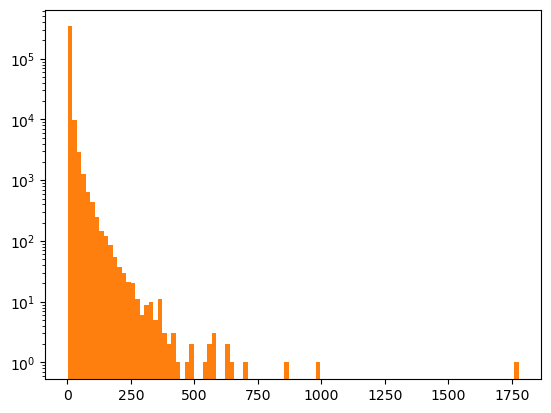

In [89]:
plt.hist(item_appearences.values(), bins=100)
plt.yscale('log')
plt.show()

In [94]:
items_with_above_average_LEs = len([val for val in item_appearences.values() if val >= 5])
LEs_of_above_average_items = sum([val for val in item_appearences.values() if val >= 5])

print(f"{items_with_above_average_LEs=}, {LEs_of_above_average_items=}")

items_with_above_average_LEs=72158, LEs_of_above_average_items=1204546


In [106]:
# Evaluate relistening on per user basis
overall_top_relistened = 0
overall_num_relistened = 0
overall_percentage_relistend = 0

all_top_relistened = []
all_num_relistened = []
all_percentage_relistend = []

for user in tqdm.tqdm(users):
    filename = f"user_split/listening_events_2019_{user}.tsv"
    events = load_file(filename)
    events = preprocess(events)
    
    item_listening = events["item"].value_counts()
    item_relistening = item_listening[item_listening > 1] - 1
    
    top_relistened = item_relistening[0]
    num_relistened = item_relistening.sum()
    percentage_relistend = num_relistened / len(events)
    
    all_top_relistened.append(top_relistened)
    all_num_relistened.append(num_relistened)
    all_percentage_relistend.append(percentage_relistend)
    
    if top_relistened > overall_top_relistened:
        overall_top_relistened = top_relistened
    if num_relistened > overall_num_relistened:
        overall_num_relistened = num_relistened
    if percentage_relistend > overall_percentage_relistend:
        overall_percentage_relistend = percentage_relistend
        
print(f"{overall_top_relistened=}, {overall_num_relistened=}, {overall_percentage_relistend=}")

100%|██████████| 150/150 [13:15<00:00,  5.31s/it]

overall_top_relistened=1765, overall_num_relistened=36334, overall_percentage_relistend=0.9553686664723761


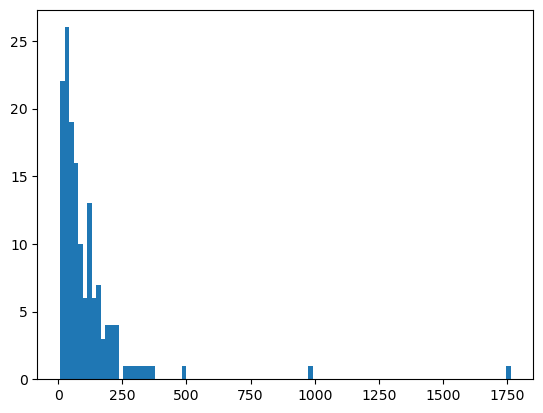

In [107]:
plt.hist(all_top_relistened, bins=100)
# plt.yscale('log')
plt.show()

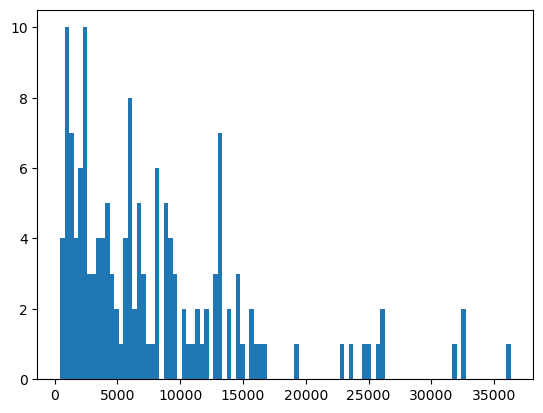

In [108]:
plt.hist(all_num_relistened, bins=100)
# plt.yscale('log')
plt.show()

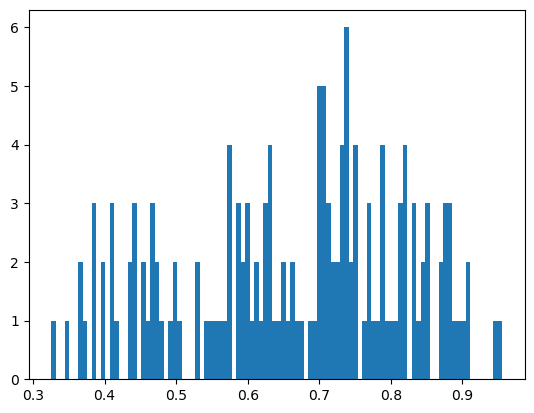

In [109]:
plt.hist(all_percentage_relistend, bins=100)
# plt.yscale('log')
plt.show()

In [120]:
avg_top_relistened = sum(all_top_relistened)/len(all_top_relistened)
avg_num_relistened = sum(all_num_relistened)/len(all_num_relistened)
avg_percentage_relistend = sum(all_percentage_relistend)/len(all_percentage_relistend)
print(f"{avg_top_relistened=}, {avg_num_relistened=}, {avg_percentage_relistend=}")

avg_top_relistened=111.28666666666666, avg_num_relistened=7982.513333333333, avg_percentage_relistend=0.6639343652628651


In [119]:
list(zip(all_top_relistened, all_num_relistened, all_percentage_relistend))[:5]

[(89, 3657, 0.8422385997236297),
 (313, 5704, 0.6228434155929242),
 (37, 8111, 0.7717411988582302),
 (31, 9274, 0.5766695684616341),
 (68, 1880, 0.5770411295273173)]